# Porto Seguro’s Safe Driver Prediction


<br><font color=blue>The aim of this compitation is to predict probability that a driver will intiate an auto insurance claim next year.A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers. </font>


# Import library

In [22]:
#Import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import roc_curve,auc
import xgboost as xgb
import lightgbm as lgb
seed =45
% matplotlib inline

## Read data set

In [23]:
#path = '../input/'
path = 'dataset/'
nrows = 10000
#nrwos =None
train = pd.read_csv(path+'train.csv',na_values=-1, nrows=nrows)
test = pd.read_csv(path+'test.csv',na_values=-1, nrows=nrows)
print('Number rows and columns:',train.shape)
print('Number rows and columns:',test.shape)

Number rows and columns: (10000, 59)
Number rows and columns: (10000, 58)


## Explore data set

In [24]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


## Target varaiable

0    9621
1     379
Name: target, dtype: int64

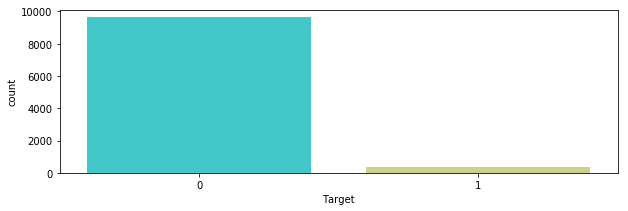

In [25]:
plt.figure(figsize=(10,3))
sns.countplot(train['target'],palette='rainbow')
plt.xlabel('Target')

train['target'].value_counts()

The 'target' variable in imbalanced 

## CORELATION PLOT

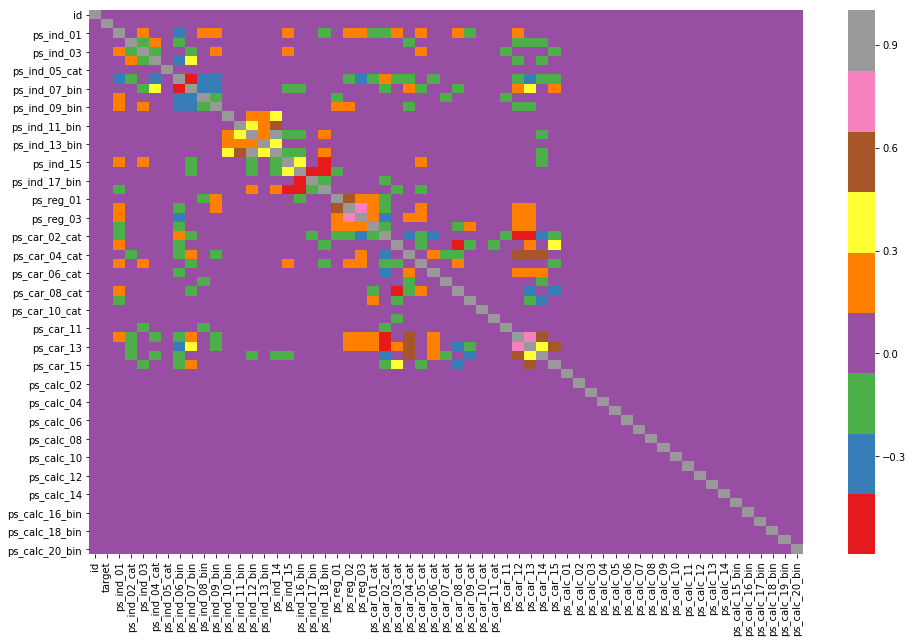

In [26]:
cor = train.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor,cmap='Set1');

###  ps calc  *  value as 0 relation with remaining varialble

In [27]:
ps_cal = train.columns[train.columns.str.startswith('ps_calc')] 
train = train.drop(ps_cal,axis =1)
test = test.drop(ps_cal,axis=1)
train.shape

(10000, 39)

In [28]:
train['target'] = train['target'].astype('category')

# Missing value is data set

"""Values of -1 indicate that the feature was missing from the observation. 
The target columns signifies whether or not a claim was filed for that policy holder.""

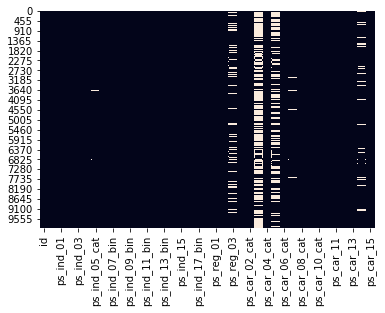

In [29]:
sns.heatmap(train.isnull(),cbar=False)

In [30]:
k= pd.DataFrame()
k['train']= train.isnull().sum()
k['test'] = test.isnull().sum()
k

,train,test
id,0,0.0
target,0,NaN
ps_ind_01,0,0.0
ps_ind_02_cat,1,2.0
ps_ind_03,0,0.0
ps_ind_04_cat,1,0.0
ps_ind_05_cat,99,104.0
ps_ind_06_bin,0,0.0
ps_ind_07_bin,0,0.0
ps_ind_08_bin,0,0.0


Missing value in test train data set are in same propotion and same column

In [31]:
def transform_df(df):
    df = pd.DataFrame(df)
    dcol= [c for c in train.columns if train[c].nunique()>2]
    dcol.remove('id')   
    d_median = df[dcol].median(axis=0)
    d_mean = df[dcol].mean(axis=0)
    
    #Add mean and median column to data set having more then 2 categories
    for c in dcol:
        df[c+str('_median_range')] = (df[c].values > d_median[c]).astype(np.int8)
        df[c+str('_mean_range')] = (df[c].values > d_mean[c]).astype(np.int8)            
    return df

In [32]:
train = transform_df(train)
test = transform_df(test)

/home/sudhir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/sudhir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


In [33]:
def missing_value(df):
    col = df.columns
    for i in col:
        if df[i].isnull().sum()>0:
            df[i].fillna(df[i].mode()[0],inplace=True)

In [34]:
missing_value(train)
missing_value(test)

## Reduce memory 

In [35]:
def change_datatype(df):
    float_cols = list(df.select_dtypes(include=['int']).columns)
    for col in float_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

In [36]:
def change_datatype_float(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        df[col] = df[col].astype(np.float32)

In [37]:
change_datatype(train)
change_datatype(test)
change_datatype_float(train)
change_datatype_float(test)

# Univariate analysis

In [38]:
def basic_details(df): 
    k = pd.DataFrame()
    k['N unique value'] = df.nunique()
    k['Missing value'] = df.isnull().sum()
    k['dtype'] = df.dtypes
    return k
basic_details(train)

,N unique value,Missing value,dtype
id,10000,0,int16
target,2,0,category
ps_ind_01,8,0,int8
ps_ind_02_cat,4,0,float32
ps_ind_03,12,0,int8
ps_ind_04_cat,2,0,float32
ps_ind_05_cat,7,0,float32
ps_ind_06_bin,2,0,int8
ps_ind_07_bin,2,0,int8
ps_ind_08_bin,2,0,int8


In [39]:
def category_col(df):
    c_col = df.columns
    to_cat_col =[]
    for i in c_col:
        if df[i].nunique()<=104:
            to_cat_col.append(i)
    return to_cat_col


tot_cat_col = category_col(train)

In [41]:
num_col = [c for c in train.columns if c not in tot_cat_col]
#num_col.append('ps_car_15')
#train['ps_car_15'] = train['ps_car_15'].astype('float32')
#test['ps_car_15'] = test['ps_car_15'].astype('float32')
num_col.remove('id')
num_col

['ps_reg_03', 'ps_car_13', 'ps_car_14']

# Determine outliers in dataset

In [42]:
def outlier(df,columns):
    for i in columns:
        quartile_1,quartile_3 = np.percentile(df[i],[25,75])
        quartile_f,quartile_l = np.percentile(df[i],[1,99])
        IQR = quartile_3-quartile_1
        lower_bound = quartile_1 - (1.5*IQR)
        upper_bound = quartile_3 + (1.5*IQR)
        print(i,lower_bound,upper_bound,quartile_f,quartile_l)
        
        df[i].loc[df[i] < lower_bound] = quartile_f
        df[i].loc[df[i] > upper_bound] = quartile_l
        
num_col = ['ps_reg_03', 'ps_car_13', 'ps_car_14']
outlier(train,num_col)
outlier(test,num_col)

ps_reg_03 0.132419899106 1.53175874054 0.415331184864 1.85219804049


/home/sudhir/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


ps_car_13 0.317481383681 1.25459860265 0.440648952425 1.61412685871
ps_car_14 0.290922641754 0.45982170105 0.288790583611 0.520481533408
ps_reg_03 0.159167729318 1.52326419204 0.419813931286 1.85256068468
ps_car_13 0.320049203932 1.26199767739 0.452032839358 1.62408677697
ps_car_14 0.289156630635 0.460881307721 0.288790583611 0.521360701919


# Split data set

In [43]:
X = train.drop(['target','id'],axis=1)
y = train['target'].astype('category')
x_test = test.drop('id',axis=1)

# Hyper parameter tuning

In [46]:
"""xg_cl = xgb.XGBClassifier(max_depth=4,learning_rate=0.1,n_estimators=5300,objective='binary:logistic',
                          min_child_weight=1,scale_pos_weight=1)
param = {'max_depth':[3,4,5,7,10],
         'learning_rate':[0.01,0.03,0.07,0.1,0.3,0.5],
         'min_child_weight':[1,3,5,7,10],
         'reg_lambda':[0.1,0.5,1,1.3,1.7,2.5],
         'reg_alpha':[1,1.5,3,8,10,12,15],
         'gamma':[0.1,0.5,1,2,5,10],
         'subsample':[0.4,0.5,0.6,0.7,0.8,0.9,1],
        'colsample_bytree':[0.4,0.5,0.6,0.7,0.8,0.9,1],
         'scale_pos_weight':[0.5,1,2,3,5,10]}
clf = GridSearchCV(xg_cl,param,scoring='roc_auc',refit=True,cv=10)

clf.fit(X,y)
print('Best roc_auc: {:.4}, with best params: {}'.format(clf.best_score_, clf.best_params_))
"""

"xg_cl = xgb.XGBClassifier(max_depth=4,learning_rate=0.1,n_estimators=5300,objective='binary:logistic',\n                          min_child_weight=1,scale_pos_weight=1)\nparam = {'max_depth':[3,4,5,7,10],\n         'learning_rate':[0.01,0.03,0.07,0.1,0.3,0.5],\n         'min_child_weight':[1,3,5,7,10],\n         'reg_lambda':[0.1,0.5,1,1.3,1.7,2.5],\n         'reg_alpha':[1,1.5,3,8,10,12,15],\n         'gamma':[0.1,0.5,1,2,5,10],\n         'subsample':[0.4,0.5,0.6,0.7,0.8,0.9,1],\n        'colsample_bytree':[0.4,0.5,0.6,0.7,0.8,0.9,1],\n         'scale_pos_weight':[0.5,1,2,3,5,10]}\nclf = GridSearchCV(xg_cl,param,scoring='roc_auc',refit=True,cv=10)\n\nclf.fit(X,y)\nprint('Best roc_auc: {:.4}, with best params: {}'.format(clf.best_score_, clf.best_params_))\n"

# Gini metric

In [44]:
def gini(y, pred):
    fpr, tpr, thr = roc_curve(y, pred, pos_label=1)
    g = 2 * auc(fpr, tpr) -1
    return g

def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred)

# XGBoost

In [45]:
def runXGB(xtrain,xvalid,ytrain,yvalid,xtest,eta=0.07,num_rounds=100):
    params = {
        'objective':'binary:logistic',        
        'max_depth':4,
        'learning_rate':eta,
        'eval_metric':'auc',
        'min_child_weight':6,
        'subsample':0.8,
        'colsample_bytree':0.8,
        'seed':seed,
        'reg_lambda':1.3,
        'reg_alpha':8,
        'gamma':10,
        'scale_pos_weight':1.6
        #'n_thread':-1
    }
    
    dtrain = xgb.DMatrix(xtrain,label=ytrain)
    dvalid = xgb.DMatrix(xvalid,label=yvalid)
    dtest = xgb.DMatrix(xtest)
    watchlist = [(dtrain,'train'),(dvalid,'test')]
    
    model = xgb.train(params,dtrain,num_rounds,watchlist,early_stopping_rounds=50,verbose_eval=50)
    pred = model.predict(dvalid,ntree_limit=model.best_ntree_limit)
    pred_test = model.predict(dtest,ntree_limit=model.best_ntree_limit)
    return pred_test,model
    

In [47]:
kf = StratifiedKFold(n_splits=10,random_state=seed,shuffle=True)
pred_test_full =0
cv_score = []
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    
    pred_test,xg_model = runXGB(xtr,xvl,ytr,yvl,x_test,num_rounds=1000,eta=0.1)    
    pred_test_full += pred_test
    cv_score.append(xg_model.best_score)
    i+=1

1 of KFold 10
[0]	train-auc:0.5	test-auc:0.5
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.661438	test-auc:0.634353
[100]	train-auc:0.679339	test-auc:0.647688
Stopping. Best iteration:
[95]	train-auc:0.674081	test-auc:0.650858

2 of KFold 10
[0]	train-auc:0.5	test-auc:0.5
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.661648	test-auc:0.641058
[100]	train-auc:0.672427	test-auc:0.635368
Stopping. Best iteration:
[61]	train-auc:0.666444	test-auc:0.642206

3 of KFold 10
[0]	train-auc:0.5	test-auc:0.5
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.668331	test-auc:0.614427
[100]	train-auc:0.681651	test-auc:0.619556
[150]	train-auc:0.68631	test-auc:0.617464
[200]	t

# Model accuracy

In [48]:
print(cv_score)
print('Mean cv_score',np.mean(cv_score))

[0.650858, 0.642206, 0.635915, 0.642658, 0.598151, 0.638336, 0.611541, 0.681981, 0.588604, 0.629376]
Mean cv_score 0.6319626


In [57]:
pred_xgb = pred_test_full/kf.n_splits
pred_xgb[:5]

array([ 0.06403705,  0.07313596,  0.07797827,  0.06124066,  0.08642397])

# Important Features

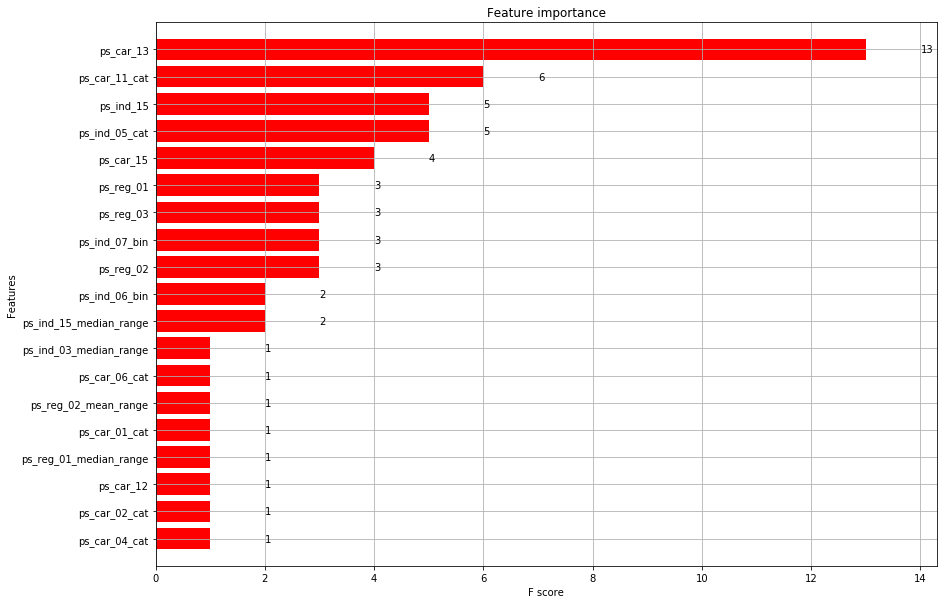

In [50]:
fig,ax = plt.subplots(figsize=(14,10))
xgb.plot_importance(xg_model,ax=ax,height=0.8,color='r')
#plt.tight_layout()
plt.show()

# Predict for unsen data set

In [51]:
y_pred = pred_xgb
submit = pd.DataFrame({'id':test['id'],'target':y_pred})
#submit.to_csv('xgb_porto.csv',index=False)
submit.to_csv('xgb_porto.csv.gz',index=False,compression='gzip') 

# Light GBM

In [52]:
def runLGB(train,valid,y_train,y_valid,test,eta=0.5,num_rounds=10,early_stop=50,max_depth=10):
    
    param = {
            'objective':'binary',
            'boosting':'gbdt',
            'learning_rate':eta,            
            'metric':'auc',
            'bagging_fraction':0.8,
            #'bagging_freq':5,
            'bagging_seed':seed,
            'num_leaves':100,
            'feature_fraction':0.8,
            #'verbose':10,            
            'min_child_weight':10,
            'max_depth':max_depth,
            'reg_alpha':1.5, 
            'reg_lambda':5,
            'scale_pos_weight':5       
            #'nthread':-1           
            }
   
    lgtrain = lgb.Dataset(train,label=y_train)
    lgvalid = lgb.Dataset(valid,label=y_valid)
    
    model=lgb.train(param,lgtrain,num_rounds,valid_sets=lgvalid,
              early_stopping_rounds=early_stop,verbose_eval=50 )
    #lg_pred = model.predict(xvl,num_iteration=model.best_iteration)
    pred = model.predict(test,num_iteration=model.best_iteration)    
    return pred,model

In [53]:
#Kfold
kf = StratifiedKFold(n_splits =5,random_state=seed,shuffle=True)
pred_test_full=0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index], X.loc[test_index]    
    ytr,yvl = y[train_index], y[test_index]
    
    pred_test,lg_model = runLGB(xtr,xvl,ytr,yvl,x_test,eta=0.1,num_rounds=1000,max_depth=7)
    pred_test_full +=pred_test
    cv_score.append(lg_model.best_score)
    i+=1

1 of KFold 5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.599802
Early stopping, best iteration is:
[18]	valid_0's auc: 0.627621
2 of KFold 5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.566343
Early stopping, best iteration is:
[5]	valid_0's auc: 0.629486
3 of KFold 5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.603601
Early stopping, best iteration is:
[9]	valid_0's auc: 0.620637
4 of KFold 5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.594485
Early stopping, best iteration is:
[2]	valid_0's auc: 0.621023
5 of KFold 5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.557526
Early stopping, best iteration is:
[8]	valid_0's auc: 0.581642


In [54]:
pred_lgb = pred_test_full/kf.n_splits

# Important Features

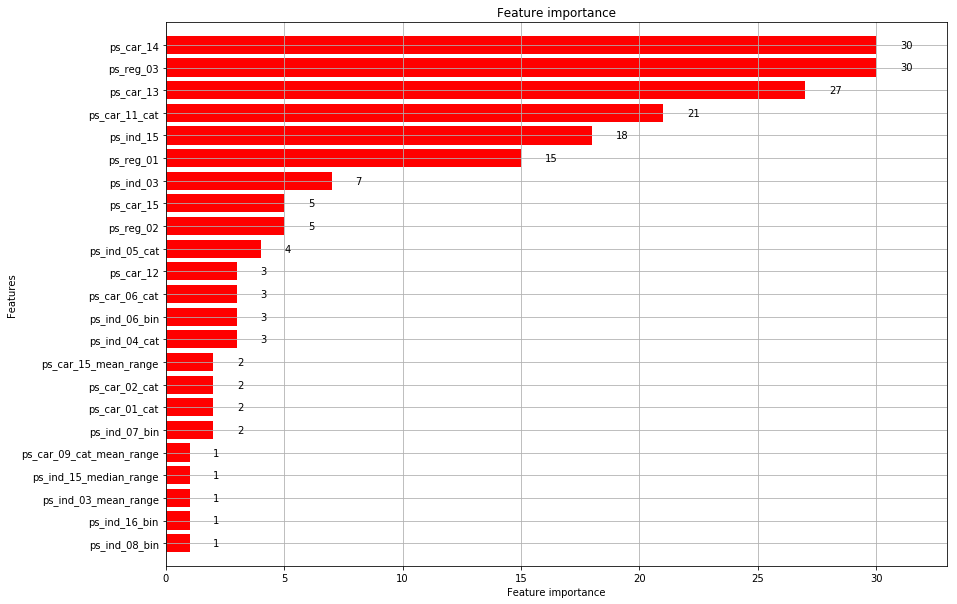

In [55]:
fig,ax = plt.subplots(figsize=(14,10))
lgb.plot_importance(lg_model,ax=ax,height=0.8,color='r')
#plt.tight_layout()
plt.show()

In [58]:
y_pred = pred_lgb*0.7+pred_xgb*0.3
submit = pd.DataFrame({'id':test['id'],'target':y_pred})
#submit.to_csv('xglg_porto.csv',index=False)
submit.to_csv('lr_porto.csv.gz',index=False,compression='gzip') 
submit.head()

,id,target
0,0,0.064037
1,1,0.073136
2,2,0.077978
3,3,0.061241
4,4,0.086424


# Thank you for visiting